## Importing libraries and combining the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from collections import Counter
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
mmScaler = MinMaxScaler()
sScaler = StandardScaler()

In [2]:
df1 = pd.read_csv('hdb_nearest_bus.csv')
# print the dataset 
df1

,Unnamed: 0,Unnamed: 1,BusStopCode,RoadName,Description,Latitude,Longitude,UpDown,LeftRight,Distance,Postal
0,26103.0,457,43581,Bt Batok West Ave 5,Blk 347,1.362519,103.751384,-15,0,95.032670,650383
1,NaN,458,43589,Bt Batok West Ave 5,Opp Blk 347,1.362273,103.751532,-15,0,76.282252,650383
2,38564.0,457,43581,Bt Batok West Ave 5,Blk 347,1.362519,103.751384,-15,0,100.970052,650384
3,NaN,458,43589,Bt Batok West Ave 5,Opp Blk 347,1.362273,103.751532,-15,0,103.767223,650384
4,38593.0,470,43649,Bt Batok West Ave 7,HomeTeamNS,1.365458,103.750602,-15,1,185.836015,650388
...,...,...,...,...,...,...,...,...,...,...,...
780,NaN,128,65269,Punggol Ctrl,Blk 162B,1.396710,103.914672,18,7,164.042097,820643
781,50968.0,393,67499,Sengkang West Ave,Fernvale Pr Sch,1.390680,103.874679,10,6,193.928437,792407
782,78835.0,88,72021,Bedok Reservoir Rd,Blk 646,1.330965,103.906322,16,-6,107.509833,410647
783,NaN,89,72029,Bedok Reservoir Rd,Opp Blk 646,1.330864,103.906552,16,-6,133.086871,410647


In [3]:
df2 = pd.read_csv('hdb_to_mrt_all.csv')
# print the dataset 
df2

C:\Users\samik\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3203: DtypeWarning: Columns (39) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,month,town,flat_type,blk_no,street,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,no,lng_mrt,lat_mrt,mahattan_distance,mrt_cbd_dist,mrt_cbd_time,hdb_cbd_distance,hdb_cbd_time,hdb_to_mrtdist,sgd_persqm
0,26103,2017-03,BUKIT BATOK,4 ROOM,383,BT BATOK WEST AVE 5,07 TO 09,92.0,Model A,2005,...,25,103.761535,1.379002,20620.13889,18877.9,23.801667,19015.7,22.508333,2885.65,4836.96
1,26104,2017-04,BUKIT BATOK,4 ROOM,383,BT BATOK WEST AVE 5,19 TO 21,90.0,Model A,2005,...,25,103.761535,1.379002,20620.13889,18877.9,23.801667,19015.7,22.508333,2885.65,5143.20
2,26105,2017-05,BUKIT BATOK,4 ROOM,383,BT BATOK WEST AVE 5,01 TO 03,90.0,Model A,2005,...,25,103.761535,1.379002,20620.13889,18877.9,23.801667,19015.7,22.508333,2885.65,4388.89
3,26106,2017-09,BUKIT BATOK,5 ROOM,383,BT BATOK WEST AVE 5,10 TO 12,115.0,Improved,2005,...,25,103.761535,1.379002,20620.13889,18877.9,23.801667,19015.7,22.508333,2885.65,4782.61
4,26107,2017-12,BUKIT BATOK,4 ROOM,383,BT BATOK WEST AVE 5,10 TO 12,90.0,Model A,2005,...,25,103.761535,1.379002,20620.13889,18877.9,23.801667,19015.7,22.508333,2885.65,4588.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89618,16451,2018-05,CHOA CHU KANG,4 ROOM,152,JLN TECK WHYE,07 TO 09,101.0,Model A,1998,...,107,103.758034,1.378619,20966.20658,18154.7,22.730000,18297.9,23.383333,23.24,3287.13
89619,16455,2018-08,CHOA CHU KANG,4 ROOM,152,JLN TECK WHYE,13 TO 15,101.0,Model A,1998,...,107,103.758034,1.378619,20966.20658,18154.7,22.730000,18297.9,23.383333,23.24,3712.87
89620,16459,2018-11,CHOA CHU KANG,4 ROOM,152,JLN TECK WHYE,01 TO 03,100.0,Model A,1998,...,107,103.758034,1.378619,20966.20658,18154.7,22.730000,18297.9,23.383333,23.24,3250.00
89621,16463,2020-03,CHOA CHU KANG,4 ROOM,152,JLN TECK WHYE,04 TO 06,100.0,Model A,1998,...,107,103.758034,1.378619,20966.20658,18154.7,22.730000,18297.9,23.383333,23.24,3350.00


In [4]:
# combined = df2.merge(df1, on=['Postal'])

In [5]:
combined = df2
combined.columns

Index(['Unnamed: 0', 'month', 'town', 'flat_type', 'blk_no', 'street',
       'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price', 'Unnamed: 0.1', 'max_floor_lvl',
       'year_completed', 'residential', 'commercial', 'market_hawker',
       'miscellaneous', 'multistorey_carpark', 'precinct_pavilion',
       'bldg_contract_town', 'total_dwelling_units', '1room_sold',
       '2room_sold', '3room_sold', '4room_sold', '5room_sold', 'exec_sold',
       'multigen_sold', 'studio_apartment_sold', '1room_rental',
       '2room_rental', '3room_rental', 'other_room_rental', 'lat_hdb',
       'lng_hdb', 'building', 'addr', 'Postal', 'SUBZONE_NO', 'SUBZONE_N',
       'SUBZONE_C', 'PLN_AREA_N', 'PLN_AREA_C', 'REGION_N', 'REGION_C',
       'MRT_NAME', 'MRT_ID', 'line', 'no', 'lng_mrt', 'lat_mrt',
       'mahattan_distance', 'mrt_cbd_dist', 'mrt_cbd_time', 'hdb_cbd_distance',
       'hdb_cbd_time', 'hdb_to_mrtdist', 'sgd_persqm'],
      dtyp

In [6]:
# combined = combined.drop(['no','Unnamed: 0_x','Unnamed: 0.1','lat_hdb','lng_hdb','lng_mrt', 'lat_mrt','Unnamed: 0_y', 'Unnamed: 1',
#        'BusStopCode','Description', 'Latitude', 'Longitude',
#        'UpDown', 'LeftRight', 'RoadName', 'line', 'MRT_ID'], axis=1)

In [7]:
combined = combined.drop(['no','Unnamed: 0','Unnamed: 0.1','lat_hdb','lng_hdb','lng_mrt', 'lat_mrt', 'MRT_ID', ], axis=1)
combined = combined.rename(columns = {'line': 'mrt_line', 'distance': 'hdb_bus_dist'})

## Adjusting for inflation 
to be done

In [8]:
#https://eservices.mas.gov.sg/statistics/calculator/GoodsAndServices.aspx
    
def adjustment(oldprice, date):
    if "2022" in date:
        return 0.96*oldprice
    elif "2021" in date:
        return 1.01*oldprice
    elif "2020" in date:
        return 1.03*oldprice
    elif "2019" in date:
        return 1.02*oldprice
    elif "2018" in date:
        return 1.01*oldprice
    elif "2017" in date:
        return oldprice
    

combined['real_price'] = combined.apply(lambda row: adjustment(row.resale_price, row.month), axis=1)
combined['real_price_persqm'] = combined.apply(lambda row: adjustment(row.sgd_persqm, row.month), axis=1)

## making remaining lease a continuous variable 


In [10]:
def conversion(remaining):
    total = float(remaining[:2])
    if len(remaining)>10:
        total += float(remaining[9:11])/12.0
    return total
        

combined['lease_remaining'] = combined.apply(lambda row: conversion(row.remaining_lease), axis=1)
combined

,month,town,flat_type,blk_no,street,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,...,mahattan_distance,mrt_cbd_dist,mrt_cbd_time,hdb_cbd_distance,hdb_cbd_time,hdb_to_mrtdist,sgd_persqm,real_price,real_price_persqm,lease_remaining
0,2017-03,BUKIT BATOK,4 ROOM,383,BT BATOK WEST AVE 5,07 TO 09,92.0,Model A,2005,86 years 11 months,...,20620.13889,18877.9,23.801667,19015.7,22.508333,2885.65,4836.96,445000.0,4836.9600,86.916667
1,2017-04,BUKIT BATOK,4 ROOM,383,BT BATOK WEST AVE 5,19 TO 21,90.0,Model A,2005,86 years 11 months,...,20620.13889,18877.9,23.801667,19015.7,22.508333,2885.65,5143.20,462888.0,5143.2000,86.916667
2,2017-05,BUKIT BATOK,4 ROOM,383,BT BATOK WEST AVE 5,01 TO 03,90.0,Model A,2005,86 years 10 months,...,20620.13889,18877.9,23.801667,19015.7,22.508333,2885.65,4388.89,395000.0,4388.8900,86.833333
3,2017-09,BUKIT BATOK,5 ROOM,383,BT BATOK WEST AVE 5,10 TO 12,115.0,Improved,2005,86 years 05 months,...,20620.13889,18877.9,23.801667,19015.7,22.508333,2885.65,4782.61,550000.0,4782.6100,86.416667
4,2017-12,BUKIT BATOK,4 ROOM,383,BT BATOK WEST AVE 5,10 TO 12,90.0,Model A,2005,86 years 03 months,...,20620.13889,18877.9,23.801667,19015.7,22.508333,2885.65,4588.89,413000.0,4588.8900,86.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89618,2018-05,CHOA CHU KANG,4 ROOM,152,JLN TECK WHYE,07 TO 09,101.0,Model A,1998,78 years 08 months,...,20966.20658,18154.7,22.730000,18297.9,23.383333,23.24,3287.13,335320.0,3320.0013,78.666667
89619,2018-08,CHOA CHU KANG,4 ROOM,152,JLN TECK WHYE,13 TO 15,101.0,Model A,1998,78 years 05 months,...,20966.20658,18154.7,22.730000,18297.9,23.383333,23.24,3712.87,378750.0,3749.9987,78.416667
89620,2018-11,CHOA CHU KANG,4 ROOM,152,JLN TECK WHYE,01 TO 03,100.0,Model A,1998,78 years 02 months,...,20966.20658,18154.7,22.730000,18297.9,23.383333,23.24,3250.00,328250.0,3282.5000,78.166667
89621,2020-03,CHOA CHU KANG,4 ROOM,152,JLN TECK WHYE,04 TO 06,100.0,Model A,1998,76 years 10 months,...,20966.20658,18154.7,22.730000,18297.9,23.383333,23.24,3350.00,345050.0,3450.5000,76.833333


# What are the variables available and what do they mean?

Continuous Variables:
`floor_area_sqm`: The size of the housing in squared meters <br><br>
`resale_price`: The resale price, not adjusted to 2017 housing price. These are the nominal prices. <br><br>
`max_floor_lvl`: The highest level in that HDB <br><br>
`mahattan_distance`: A straight line distance from the nearest MRT to the CBD MRT (Raffles Place MRT) <br><br>
`mrt_cbd_dist`: The car travelling distance between the MRT and the CBD MRT (Raffles Place MRT) <br><br>
`mrt_cbd_time`: The car travlling time between the MRT and the CBD MRT (Raffles Place MRT) <br><br>
`hdb_cbd_distance`: The car travelling distance between the HDB and the CBD MRT (Raffles Place MRT) <br><br>
`hdb_cbd_time`: The car travelling time between the HDB and the CBD MRT (Raffles Place MRT) <br><br>
`hdb_to_mrtdist`: The car travelling distance between the HDB and the MRT (Raffles Place MRT) <br><br>
`sgd_persqm`: The nominal resale price per squared meter of the HDB <br><br>
`hdb_bus_dist`: Distance from the HDB to the nearest Bus Stop <br><br>
`real_price`: The resale price, adjusted to 2017 housing price, using MAS adjustment calculator <br><br>
`real_price_persqm`: The resale price per squared meter, adjusted to 2017 housing price, using MAS adjustment calculator <br>
`lease_remaining`: The number of years in decimal of lease remaining <br><br>
<br>

`'total_dwelling_units', '1room_sold', '2room_sold', '3room_sold','4room_sold', '5room_sold', 'exec_sold', 'multigen_sold','studio_apartment_sold', '1room_rental', '2room_rental', '3room_rental','other_room_rental',` <br>
the above variables were provided in the github and state how many dwellings were in the HDB, how many types of each variables were sold in the HDB. While these variables are left in the dataframe for exploratory analysis, it may not significantly affect the HDB prices. 
<br><br><br>

Categorical variables:
`month`: The month in which the HDB house was resold <br><br>
`town`: The town where the HDB is <br><br>
`flat_type`: The number of rooms in the house <br><br>
`blk_no`: The HDB Block number <br><br>
`street`: The street in which the HDB is located <br><br>
`storey_range`: The range of storeys sold. <br><br>
`flat_model`: Model A vs Improved <br><br>
`lease_commence_date`: The official start of lease for the HDB <br><br>
`remaining_lease`: The remaining lease for the HDB as a 'x years and y months' format <br><br>
`year_completed`: Year of build <br><br>
`residential`: Whether it is residential <br><br>
`commercial`: whether there are any shops in the HDB <br><br>
`market_hawker`: Whether there is a market or hawker in the HDB itself <br><br>
`miscellaneous`: Any misc facilities <br><br>
`multistorey_carpark`: Whether there is an in built carpark <br><br>
`precinct_pavilion`: Whether there is a pavilion <br><br>
`bldg_contract_town`: ???? <br><br>
`building`: ???? <br><br>
`SUBZONE_NO`: ???? <br><br>
`mrt_line`: the Line in which the nearest MRT belongs too
`SUBZONE_N`: ???? <br><br>
`SUBZONE_C`: ???? <br><br>
`PLN_AREA_N`: ???? <br><br>
`PLN_AREA_C`: ???? <br><br>
`REGION_N`: ???? <br><br>
`REGION_C`: ???? <br><br>
`MRT_NAME`: Name of the nearest MRT <br><br>

## Comparison between types of HDBs
We need to recognise that some HDBs have multistory carparks in the lower levels while others do not. 
Some HDBs have hawkers in built, others have commercial shops like value dollar shops. 

So what are the HDB facilities? 
1. Commercial!
2. Multistory carpark!
4. Precint_pavillion!

what are the combination available in the given dataset?

1. Pure residential 
2. Residential and Commercial Only
3. Residential, Commercial with carpark (6 rows only)
4. Residential and pavilion

In [11]:
residential = combined.loc[(combined['residential']=="Y") & (combined['commercial']=="N") & (combined['multistorey_carpark']=="N") & (combined['precinct_pavilion']=="N")]
res_and_comm = combined.loc[(combined['residential']=="Y") & (combined['commercial']=="Y") & (combined['multistorey_carpark']=="N") & (combined['precinct_pavilion']=="N")]
res_comm_car = combined.loc[(combined['residential']=="Y") & (combined['commercial']=="Y") & (combined['multistorey_carpark']=="Y") & (combined['precinct_pavilion']=="N")]
res_pav = combined.loc[(combined['residential']=="Y") & (combined['commercial']=="N") & (combined['multistorey_carpark']=="N") & (combined['precinct_pavilion']=="Y")]
residential.columns

Index(['month', 'town', 'flat_type', 'blk_no', 'street', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price', 'max_floor_lvl', 'year_completed',
       'residential', 'commercial', 'market_hawker', 'miscellaneous',
       'multistorey_carpark', 'precinct_pavilion', 'bldg_contract_town',
       'total_dwelling_units', '1room_sold', '2room_sold', '3room_sold',
       '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold',
       'studio_apartment_sold', '1room_rental', '2room_rental', '3room_rental',
       'other_room_rental', 'building', 'addr', 'Postal', 'SUBZONE_NO',
       'SUBZONE_N', 'SUBZONE_C', 'PLN_AREA_N', 'PLN_AREA_C', 'REGION_N',
       'REGION_C', 'MRT_NAME', 'mrt_line', 'mahattan_distance', 'mrt_cbd_dist',
       'mrt_cbd_time', 'hdb_cbd_distance', 'hdb_cbd_time', 'hdb_to_mrtdist',
       'sgd_persqm', 'real_price', 'real_price_persqm', 'lease_remaining'],
      dtype='object')

In [12]:
def printgraph(x:str,y:str):
    X=residential[[x]]
    Y=residential[[y]]
    
    titlestr = x + ' against ' + y + ' for purely residential HDBs'

    regressor = LinearRegression()
    regressor.fit(X,Y)
    y_pred = regressor.predict(X)
    plt.scatter(X, Y, color = 'red', )
    plt.plot(X, regressor.predict(X), color = 'blue')
    plt.title(titlestr)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()
    
    print("\n\n\n")
    X=res_and_comm[[x]]
    Y=res_and_comm[[y]]
    
    titlestr = x + '  against ' + y + ' for residential, commercial HDBs'

    regressor = LinearRegression()
    regressor.fit(X,Y)
    y_pred = regressor.predict(X)
    plt.scatter(X, Y, color = 'red', )
    plt.plot(X, regressor.predict(X), color = 'blue')
    plt.title(titlestr)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()
    
    print("\n\n\n")
    X=res_comm_car[[x]]
    Y=res_comm_car[[y]]
    
    titlestr = x + '  against ' + y + ' for residential, commercial, carpark HDBs'

    regressor = LinearRegression()
    regressor.fit(X,Y)
    y_pred = regressor.predict(X)
    plt.scatter(X, Y, color = 'red', )
    plt.plot(X, regressor.predict(X), color = 'blue')
    plt.title(titlestr)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()
    
    print("\n\n\n")
    X=res_pav[[x]]
    Y=res_pav[[y]]
    
    titlestr = x + '  against ' + y + ' for residential, pavilion HDBs'

    regressor = LinearRegression()
    regressor.fit(X,Y)
    y_pred = regressor.predict(X)
    plt.scatter(X, Y, color = 'red', )
    plt.plot(X, regressor.predict(X), color = 'blue')
    plt.title(titlestr)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()
    
def printmenu():
    llist = ['floor_area_sqm', 'resale_price', 'max_floor_lvl','total_dwelling_units', '1room_sold', '2room_sold', '3room_sold',
       '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold',
       'studio_apartment_sold', '1room_rental', '2room_rental', '3room_rental',
       'other_room_rental', 'mahattan_distance', 'mrt_cbd_dist',
       'mrt_cbd_time', 'hdb_cbd_distance', 'hdb_cbd_time', 'hdb_to_mrtdist',
       'sgd_persqm', 'hdb_bus_dist', 'real_price', 'real_price_persqm', 'lease_remaining']
    
    print("Below are the variables: ")
    count = 0
    for item in llist:
        print("item ", count, ": ", item)
        count +=1
        
    x_var = int(input("Choose x variable (type in the item number only!): \n"))
    y_var = int(input("Choose y variable (type in the item number only!): \n"))
    
    
    return llist[x_var], llist[y_var]

# Continuous Variables 

## User guide to using the below cell:

1. press shift + enter to run the cell. 
2. Enter the item number you wish to compare. Only numbers allowed


Below are the variables: 
item  0 :  floor_area_sqm
item  1 :  resale_price
item  2 :  max_floor_lvl
item  3 :  total_dwelling_units
item  4 :  1room_sold
item  5 :  2room_sold
item  6 :  3room_sold
item  7 :  4room_sold
item  8 :  5room_sold
item  9 :  exec_sold
item  10 :  multigen_sold
item  11 :  studio_apartment_sold
item  12 :  1room_rental
item  13 :  2room_rental
item  14 :  3room_rental
item  15 :  other_room_rental
item  16 :  mahattan_distance
item  17 :  mrt_cbd_dist
item  18 :  mrt_cbd_time
item  19 :  hdb_cbd_distance
item  20 :  hdb_cbd_time
item  21 :  hdb_to_mrtdist
item  22 :  sgd_persqm
item  23 :  hdb_bus_dist
item  24 :  real_price
item  25 :  real_price_persqm
item  26 :  lease_remaining
Choose x variable (type in the item number only!): 
26
Choose y variable (type in the item number only!): 
25


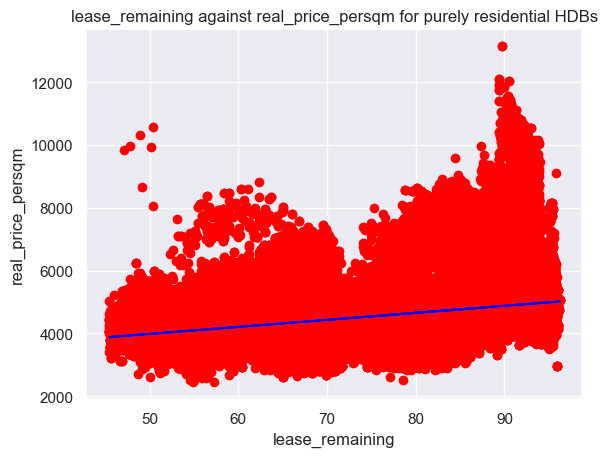

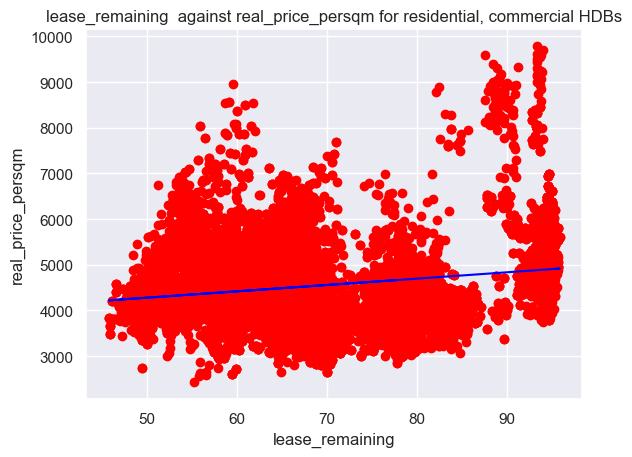

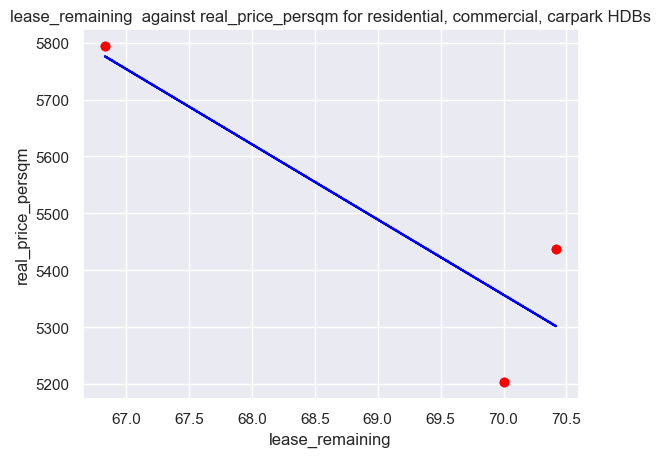

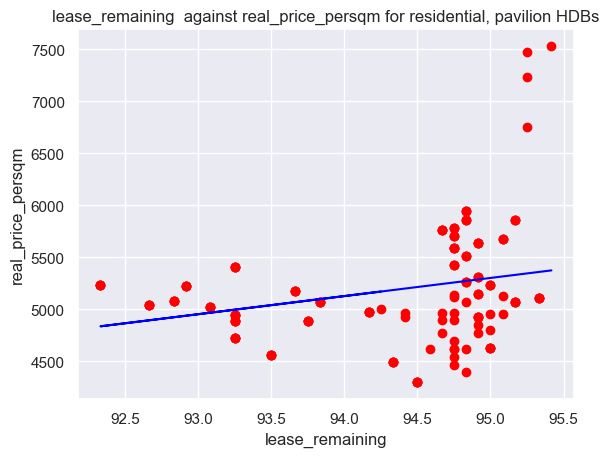

In [13]:
x_var, y_var = printmenu()
printgraph(str(x_var), str(y_var))

# Categorical Variables

The below will only allow y variable to be sgd_persqm or resale price!

## User guide to using the below cell:

1. press shift + enter to run the cell. 
2. Enter the item number you wish to compare. Only numbers allowed


In [37]:
def printgraph2(X:str,Y:str):
    titlestr = X + '  against ' + Y + ' for residential only HDBs'
    f = plt.figure(figsize=(8,8))
    ax = sb.boxplot(x=X, y=Y, data = residential).set(title = titlestr)
    plt.xticks(rotation=70)
    print("\n\n")
    
    titlestr = X + '  against ' + Y + ' for residential and commercial HDBs'
    f = plt.figure(figsize=(8,8))
    sb.boxplot(x=X, y=Y, data = res_and_comm).set(title = titlestr)
    plt.xticks(rotation=70)
    print("\n\n")
    
    titlestr = X + '  against ' + Y + ' for residential, commercial, carpark HDBs'
    f = plt.figure(figsize=(8,8))
    sb.boxplot(x=X, y=Y, data = res_comm_car).set(title = titlestr)
    plt.xticks(rotation=70)
    print("\n\n")
    
    
    titlestr = X + '  against ' + Y + ' for residential and pavilion HDBs'
    f = plt.figure(figsize=(8,8))
    sb.boxplot(x=X, y=Y, data = res_pav).set(title = titlestr)
    plt.xticks(rotation=70)
    
    
    
def printmenu2():
    llist = ['month', 'town', 'flat_type', 'blk_no', 'street', 'storey_range',
       'flat_model', 'lease_commence_date',
       'remaining_lease', 'year_completed',
       'residential', 'commercial', 'market_hawker', 'miscellaneous',
       'multistorey_carpark', 'precinct_pavilion', 'bldg_contract_town',
       'building', 'SUBZONE_NO', 'mrt_line',
       'SUBZONE_N', 'SUBZONE_C', 'PLN_AREA_N', 'PLN_AREA_C', 'REGION_N',
       'REGION_C', 'MRT_NAME']
    
    print("Below are the variables: ")
    count = 0
    for item in llist:
        print("item ", count, ": ", item)
        count +=1
        
    x_var = int(input("Choose x variable (type in the item number only!): \n"))
    
    yvar = ['resale_price','sgd_persqm','real_price', 'real_price_persqm']
    
    count = 0
    for item in yvar:
        print("item ", count, ": ", item)
        count +=1
    
    y_var = int(input("Choose y variable (type in the item number only!): \n"))
    
    
    return llist[x_var], yvar[y_var]

Below are the variables: 
item  0 :  month
item  1 :  town
item  2 :  flat_type
item  3 :  blk_no
item  4 :  street
item  5 :  storey_range
item  6 :  flat_model
item  7 :  lease_commence_date
item  8 :  remaining_lease
item  9 :  year_completed
item  10 :  residential
item  11 :  commercial
item  12 :  market_hawker
item  13 :  miscellaneous
item  14 :  multistorey_carpark
item  15 :  precinct_pavilion
item  16 :  bldg_contract_town
item  17 :  building
item  18 :  SUBZONE_NO
item  19 :  mrt_line
item  20 :  SUBZONE_N
item  21 :  SUBZONE_C
item  22 :  PLN_AREA_N
item  23 :  PLN_AREA_C
item  24 :  REGION_N
item  25 :  REGION_C
item  26 :  MRT_NAME
Choose x variable (type in the item number only!): 
1
item  0 :  resale_price
item  1 :  sgd_persqm
item  2 :  real_price
item  3 :  real_price_persqm
Choose y variable (type in the item number only!): 
3











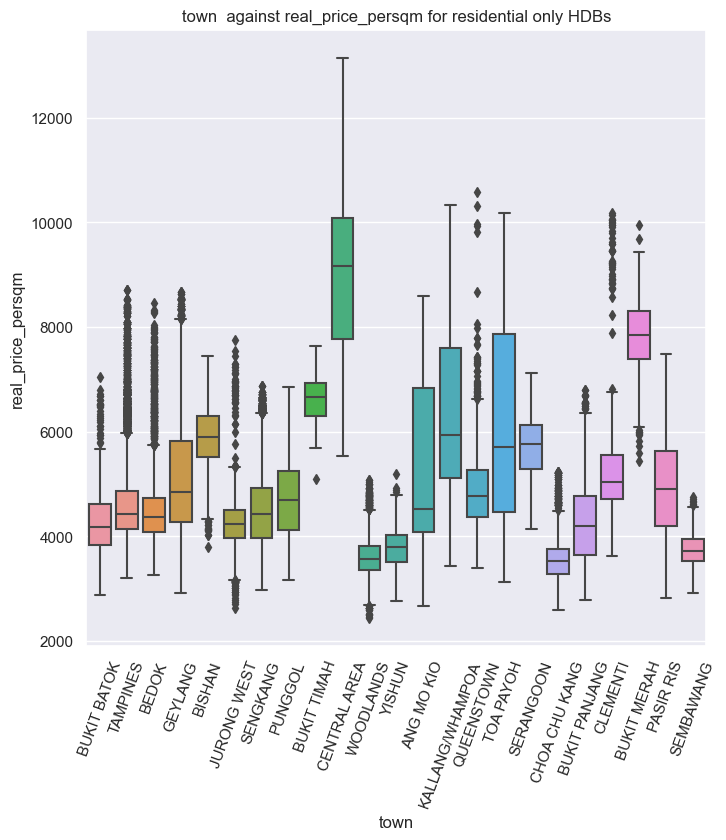

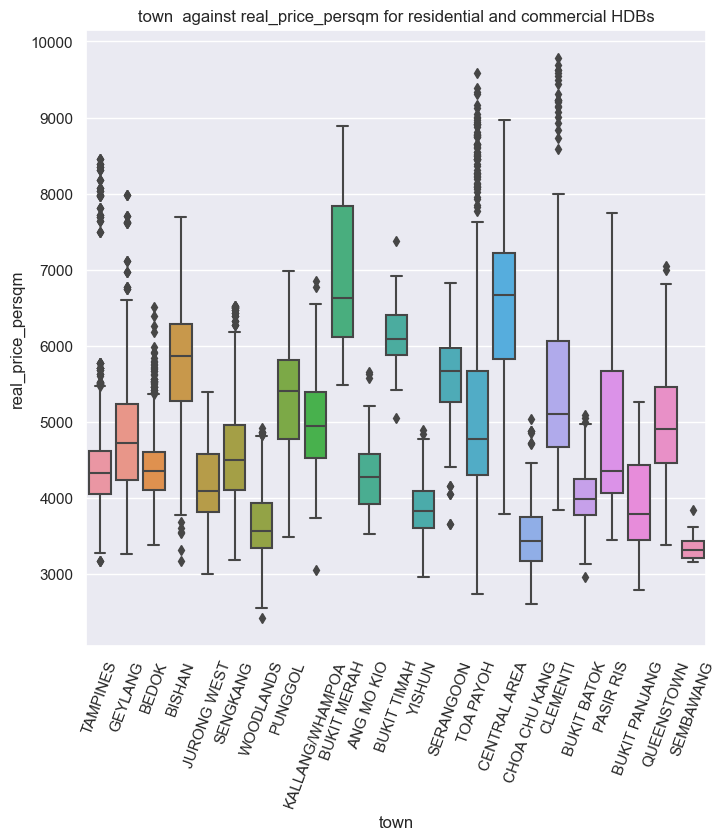

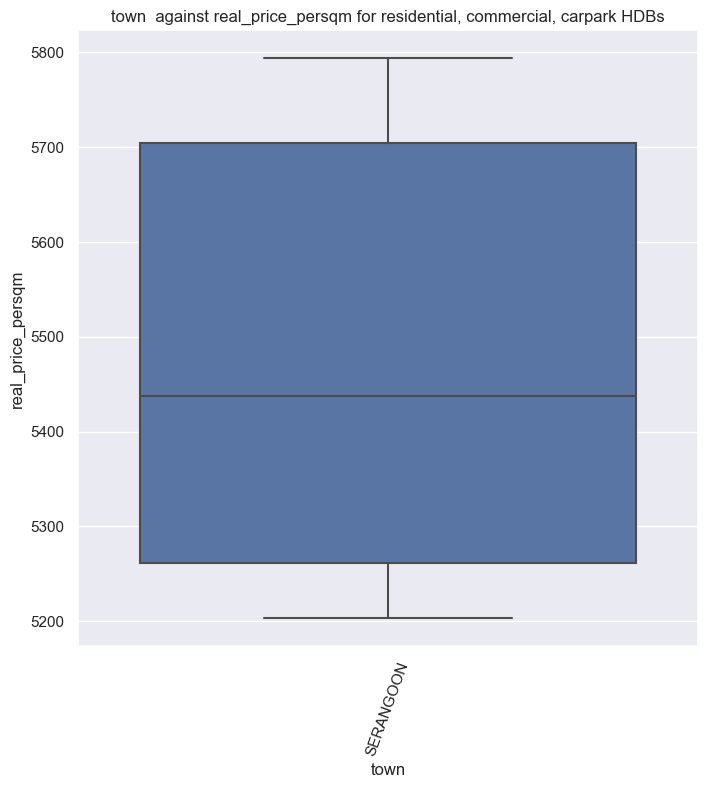

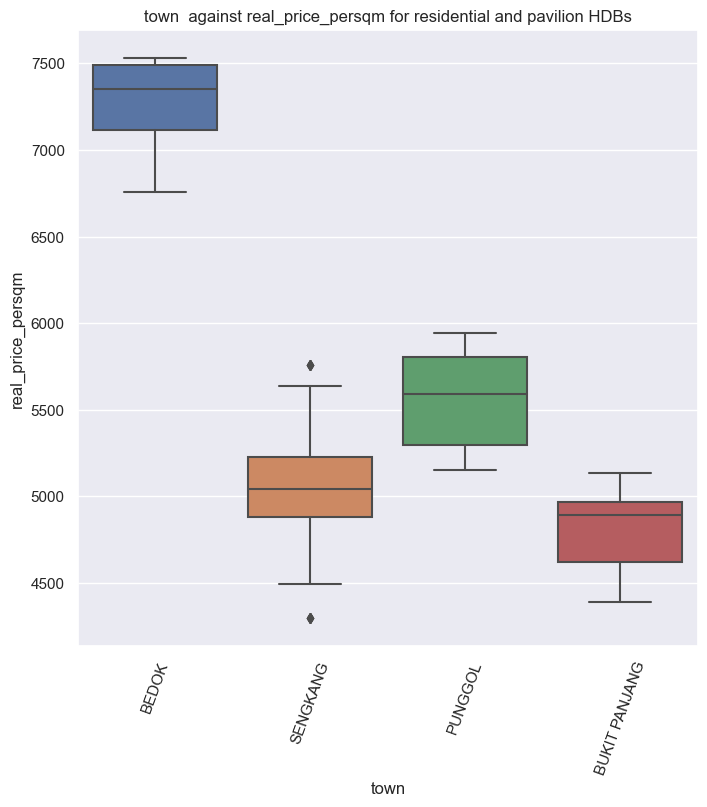

In [38]:
x_var, y_var = printmenu2()

printgraph2(x_var,y_var)